# Genetic algorithm to optimize investment in the stock market

## Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import itertools

## Assign problem hyperparameters

Two types of hyperparameters exist:
 - **Fixed parameters:** defined in the project statement
 - **Test parameters:** defined by us to test different implementations of the algorithm

In [3]:
# FIXED PARAMETERS
POPULATION_SIZE = 64 # number of individuals in population
GENERATIONS = 10000   # number of generations (evaluation rounds)
MAX_RUNS = 30 # number of runs with different random seeds

# TEST PARAMETERS
CROSSOVER_PROBABILITY = 0.8 # probability of crossover operation
MUTATION_PROBABILITY = 0.2 # probability of mutation operation
TOURNAMENT_SIZE = 3 # number of individuals participating in tournament selection

## Process datasets

Filter the data relevant for the problem in question

In [4]:
def process_data(data):
    # only relevant from 01/01/2020 onwards to 31/12/2022 (3 years)
    # convert to datetime format
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data = data[data['Date'] >= '01-01-2020']
    data = data[data['Date'] <= '31-12-2022']

    # calculate the difference between consecutive values in the 'Close' column
    value_diff = data['Close'].diff()

    # create 'Gain' and 'Loss' columns based on the 'Value_Diff'
    gain = value_diff.apply(lambda x: max(0, x))
    loss = value_diff.apply(lambda x: max(0, -x))

    # calculate the rolling sum of 'Gain' and 'Loss' for a 7-day, 14-day, and 21-day periods
    average_gain_7 =  gain.rolling(window=7).mean()
    average_loss_7 =  loss.rolling(window=7).mean()
    average_gain_14 = gain.rolling(window=14).mean()
    average_loss_14 = loss.rolling(window=14).mean()
    average_gain_21 = gain.rolling(window=21).mean()
    average_loss_21 = loss.rolling(window=21).mean()

    # calculate the Relative Strength (RS)
    rs_7 = average_gain_7/average_loss_7
    rs_14 = average_gain_14/average_loss_14
    rs_21 = average_gain_21/average_loss_21

    # calculate the Relative Strength Index (RSI)
    data['RSI7'] = 100 - (100/(1+rs_7))
    data['RSI14'] = 100 - (100/(1+rs_14))
    data['RSI21'] = 100 - (100/(1+rs_21))

    # Reset the index of the DataFrame
    data.reset_index(drop=True, inplace=True)
    return data

## Initialize DEAP

In [5]:
# create the fitness function
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", tuple, fitness=creator.FitnessMax)

# define the parameters
rsi_periods = [7, 14, 21]
lower_range = list(range(0, 101, 5))
upper_range = list(range(0, 101, 5))

# create the toolbox
toolbox = base.Toolbox()

toolbox.register("rsi_period", random.choice, rsi_periods)
toolbox.register("bound", random.choice, lower_range)

toolbox.register("attr_pool", tools.initCycle, tuple, [toolbox.rsi_period,
                                                       toolbox.bound,
                                                       toolbox.bound])

tools.initCycle
tools.initRepeat

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_pool, n=2)
toolbox.register("population",tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)

## Define simulation function

The simulation will be used in the **epigenesis** stage

            Date       Close       RSI7      RSI14      RSI21
index                                                        
105   2020-06-03   71.819000  88.334517  85.185982  70.935405
105   2020-06-03   71.819000  88.334517  85.185982  70.935405
105   2020-06-03   71.819000  88.334517  85.185982  70.935405
163   2020-08-25   80.411003  90.103035  80.096633  60.844544
222   2020-11-17   88.507500  55.133192  88.391517  70.009172
283   2021-02-17  106.415497  75.560710  87.505027  79.374915
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   2022-08-15  122.879997  73.840619  86.092709  62.112250
659   20

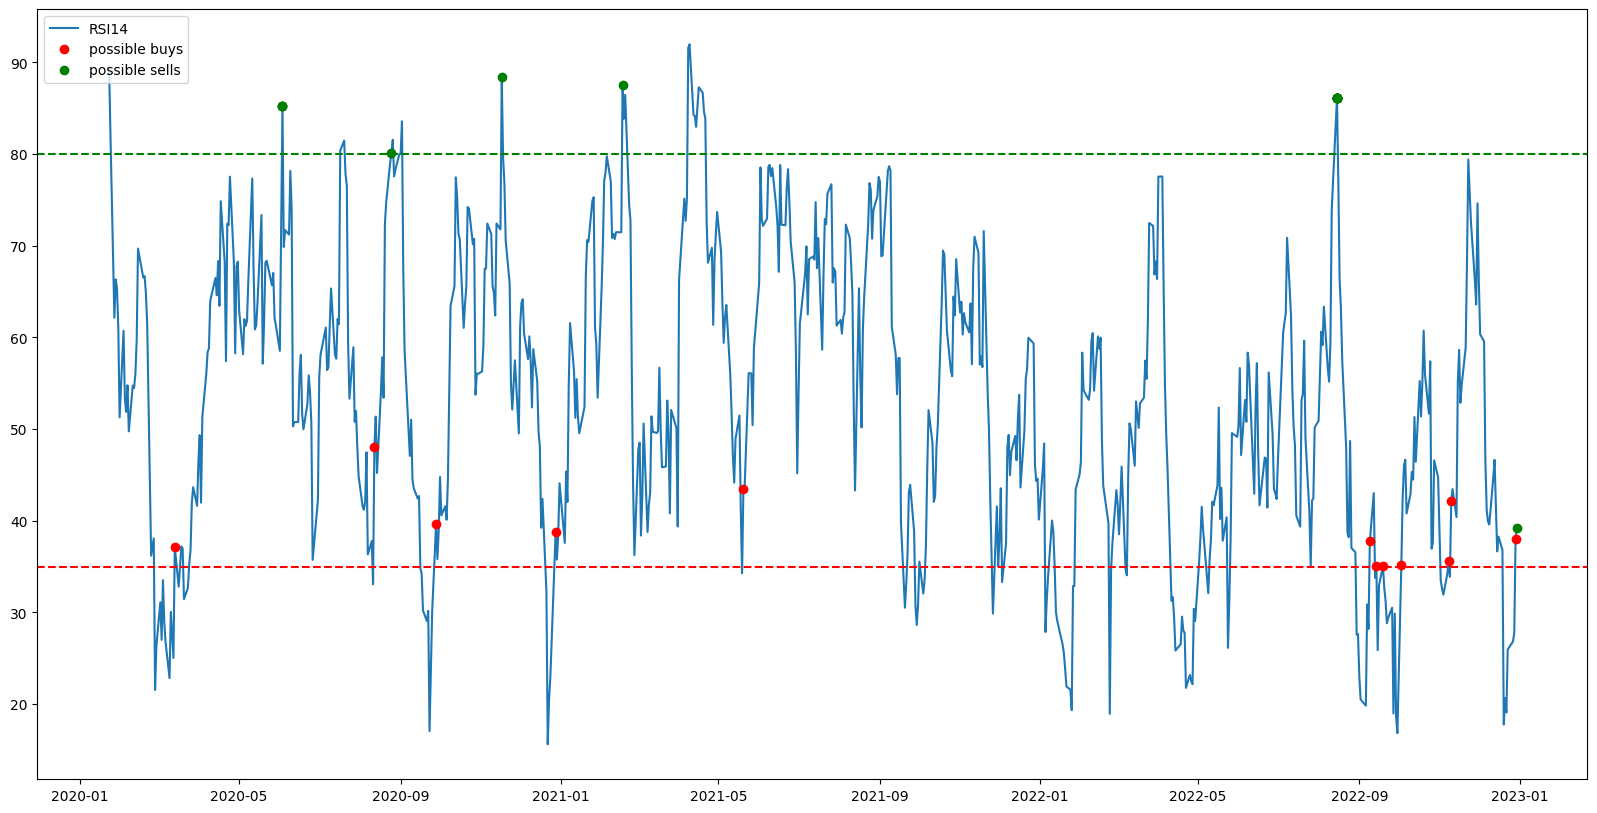

In [25]:
individual = ((21, 25, 50), (14, 35, 80))

data = pd.read_csv('data/GOOG.csv', sep=';', usecols=['Date', 'Close'])

data = process_data(data)

import matplotlib.pyplot as plt


def simulate_trade(individual, data):
    # extract the parameters from the individual chromosome
    (rsi_period_short, lower_short, upper_short), (rsi_period_long, lower_long, upper_long) = individual
    
    rsi_period_long = "RSI" + str(rsi_period_long)
    rsi_period_short = "RSI" + str(rsi_period_short)

    # based on the parameters, choose dates to buy and sell
    possible_long_buys = data[(data[rsi_period_long] >= lower_long) & 
                              ((data[rsi_period_long].shift(1) < lower_long) |
                               (data[rsi_period_long].shift(1) == np.nan))].copy()
    
    if possible_long_buys.empty:
        return 0
    
    possible_long_sells = []
    for index, row in possible_long_buys.iterrows():
        candidate_sells = data[(data['Date'] > row['Date']) &
                               (data[rsi_period_long] >= upper_long)]
        if (candidate_sells.empty):
            new_sell = dict(data.iloc[-1])
            new_sell['index'] = len(data) - 1
            possible_long_sells.append(new_sell)
            break
        else:
            new_sell = dict(candidate_sells.iloc[0])
            new_sell['index'] = candidate_sells.index[0]
            possible_long_sells.append(new_sell)
            if (index + 1 < candidate_sells.index[0]) and (index + 1 < possible_long_buys.index[-1]):
                drop_rows = [i for i in possible_long_buys.index if i > index and i < candidate_sells.index[0]]
                possible_long_buys.drop(drop_rows, inplace=True) 
            

    possible_long_sells = pd.DataFrame(possible_long_sells)
    possible_long_sells.set_index('index', inplace=True)
    print(possible_long_sells)
    print(possible_long_buys)
    

    # plot evolution of RSI and points where buys and sells are possible
    plt.figure(figsize=(20,10))
    plt.plot(data['Date'], data[rsi_period_long], label=rsi_period_long)
    plt.plot(possible_long_buys['Date'], possible_long_buys[rsi_period_long], 'ro', label='possible buys')
    plt.plot(possible_long_sells['Date'], possible_long_sells[rsi_period_long], 'go', label='possible sells')
    plt.legend(loc='upper left')
    # plot line of the lower and upper bounds
    plt.axhline(upper_long, color='green', linestyle='--')
    plt.axhline(lower_long, color='red', linestyle='--')
    plt.show()


    possible_short_buys = data[rsi_period_short][data[rsi_period_short] >= lower_short]
    possible_short_sells = data[rsi_period_short][data[rsi_period_short] <= upper_short]
    trade_dates_short = pd.merge(possible_short_buys, possible_short_sells, how='inner', left_index=True, right_index=True)

simulate_trade(individual, data)
    

In [ ]:
A = pd.DataFrame({'Date': ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04'], 'RSI7': [10, 20, 30, 40]}, index=[0, 1, 5, 7])
B = pd.DataFrame({'Date': ['2020-01-02', '2020-01-04', '2020-01-06', '2020-01-07'], 'RSI7': [10, 20, 30, 40]}, index=[1, 4, 8, 9])

A['Date'] = pd.to_datetime(A['Date'], format='%Y-%m-%d')
B['Date'] = pd.to_datetime(B['Date'], format='%Y-%m-%d')

pd.merge_asof(A, B, left_index=True, right_index=True, direction='forward', suffixes=('_left', '_right'))

## Define objective function

The objective function will be used in the **selection** stage

In [ ]:
def evaluate_results(individual):
    lower_long, upper_long, lower_short, upper_short = individual
    roi_long = (upper_long-lower_long)/(lower_long)*100 
    roi_short = (upper_short-lower_short)/(upper_short)*100
    average_roi = (roi_long + roi_short)/2
    return average_roi

toolbox.register("evaluate", evaluate_results)

## Define selection method

The selection function will be used in the **survival** stage

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

## Define mutation method

The mutation function will be used in the **mutation** stage

## Run the algorithm

In [ ]:
def algorithm(data, RSI, price, date):
    overall = []
    seed = 30
    best_individual = None
    best_fitness = None
    for i in range(MAX_RUNS):
        random.seed(i) # set random seed for each run
        print('--Run: {0}--\n'.format(i))
        # create the initial population
        pop = toolbox.population(n=POPULATION_SIZE) # create the initial population
        print(pop)
        print('Starting evolution...')

        # fitnesses = list(map(evaluate_individual, pop)) # evaluate the individuals
        # for ind, fit in zip(pop, fitnesses):
        #     ind.fitness.values = fit
    pass

folder_path = 'data'

file_list = os.listdir(folder_path)

data_dictionary = {}
RSI_dictionary = {}
price_dictionary = {}
date_dictionary = {}

for file_name in file_list:
    if file_name.endswith('.csv'):
        # extract the base name of the file (without the extension)
        df_name = os.path.splitext(file_name)[0]
        # construct the full file path
        file_path = os.path.join(folder_path, file_name)
            # read the CSV file into a DataFrame with the base name as the variable name
        data_dictionary[df_name] = pd.read_csv(file_path, sep=';', usecols=['Date', 'Close'])
        data, rsi, price, date = process_data(data_dictionary[df_name])
        data_dictionary[df_name] = data
        RSI_dictionary[df_name] = rsi
        price_dictionary[df_name] = price
        date_dictionary[df_name] = date
for df_name in data_dictionary:
    algorithm(data_dictionary[df_name], RSI_dictionary[df_name], price_dictionary[df_name], date_dictionary[df_name])